#K - Times Markov Sampling for Pascal dataset

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale



---


Connecting  to the  Google drive for easy import and export of data


---


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



---


Reading the csv file made for the dataset - And initializing the dataframe with it (currently working only for 6 classes)


---


In [3]:
pascal = pd.read_csv("/content/drive/MyDrive/Image-pixels.csv")

In [4]:
pascal.shape

(4382, 22501)



---


Append the label column in the dataset read 


---


In [5]:
col=[i for i in range(22500)]
col.append('label')
pascal.columns=col
pascal.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
         22491,   22492,   22493,   22494,   22495,   22496,   22497,   22498,
         22499, 'label'],
      dtype='object', length=22501)

## Starting with the algorithm : 


---


### K - TIMES MARKOV SAMPLING FOR SVMC


---


**Step 1** : Draw randomly N samples Siid := {zj}N
j=1 from ST . Train Siid by SVMC and obtain a preliminary
learning model f0. Let i = 0.


---



In [6]:
markov= pd.DataFrame(columns = pascal.columns)
uniqCls=list(np.sort(pascal['label'].unique()))
classCNT=len(uniqCls)
limit=250
m=classCNT*limit
mcls={i:0 for i in uniqCls}

k=5
q=1.2
acc=0

X = pascal.drop("label", axis = 1)
y = pascal['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)


---


Utility Function for loop condition


---

---


Utility loss Function


---


---


Utility function for training subsequent models


---






In [11]:
# Helper Function
def exist(dic,limit):
    for i,val in dic.items():
        if val<limit:
            return True
    return False            

def lossF(actual,pred):
    if actual==pred:
        return 1.0
    return np.exp(-2)

def train(data):    
    X = data.drop("label", axis = 1)
    y = data['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 101)
    model_linear = SVC(kernel='linear')
    model_linear.fit(X_train, y_train)

    return model_linear


---


# Step 2 To Step 7


---

**Step 2 :**  Let N+ = 0, N− = 0, t = 1.

**Step 3 :**  Draw randomly a sample zt from ST , called it the current sample. Let N+ = N+ + 1 if the label of zt is +1, or let N− = N− + 1 if the label of zt is −1.

**Step 4 :** Draw randomly another sample z∗ from ST , called it the candidate sample, and calculate the ratio α, α = e−( fi,z∗)/e−( fi,zt).

**Step 5 :** If α ≥ 1, yt y∗ = 1 accept z∗ with probability α1 = e−y∗ fi /e−yt fi . If α = 1 and yt y∗ = −1 or α < 1, accept z∗ with probability α. If there are n2 candidate samples can not be accepted continually, then set α2 = qα and accept z∗ with probability α2. If z∗ is not accepted, go to Step 4, else let zt+1 = z∗, N+ = N+ + 1 if the label of zt+1 is +1 and N+ < N/2, or let zt+1 = z∗, N− = N−+1 if the label of zt+1 is −1 and N− < N/2 (if the value α (or α1, α2) is bigger than 1, accept the candidate sample z∗ with probability 1).

**Step 6 :** If N+ +N− < N, return to Step 4, else we obtain N Markov chain samples SMar. Let i = i + 1. Train SMar by SVMC and obtain a learning model fi .


**Step 7 :** If i < k, go to Step 2, else output sign( fk ).

---





---


Loop To run the markov chain generator k times

---



In [15]:
lst=[]
predProb=[]
for km in range(2):
    # Resetting parameters for each chain
    if km!=0:
        predProb=[]
        model_linear=train(markov)
        markov= pd.DataFrame(columns = pascal.columns)
        mcls={i:0 for i in uniqCls}
    lst=[]

    i=np.random.randint(pascal.shape[0])
    z0=pascal.iloc[i]
    y0=model_linear.predict(np.array([z0.drop('label')]))[0]
    if m%classCNT==0:
        mcls[z0['label']]+=1
    while exist(mcls,limit):
        i=np.random.randint(pascal.shape[0])
        while i in lst:
            i=np.random.randint(pascal.shape[0])
        z1=pascal.iloc[i]
        y1=model_linear.predict(np.array([z1.drop('label')]))[0]
        n=lossF(z1['label'],y1)
        d=lossF(z0['label'],y0)
        p=n/d

        # Deciding of acceptance of chosen sample and its probability
        if acc==k:
            acc=0
            p2=q*p
            p2=min(p2,1)
            predProb.append([z1['label'],y1,p2])
            markov=markov.append(z1)
            lst.append(i)
            z0=z1
            mcls[z1['label']]+=1
            acc+=1
        elif p==1 and z0['label']==z1['label']:
            n=np.exp(-y1*z1['label'])
            d=np.exp(-y0*z0['label'])

            p1=n/d
            p1=min(p1,1)
            predProb.append([z1['label'],y1,p1])
            markov=markov.append(z1)
            lst.append(i)
            z0=z1
            mcls[z1['label']]+=1
            acc+=1
        elif p<1:
            predProb.append([z1['label'],y1,p])
            markov=markov.append(z1)
            lst.append(i)
            z0=z1
            mcls[z1['label']]+=1
            acc+=1
        elif p==1 and z0['label']!=z1['label']:
            predProb.append([z1['label'],y1,p])
            markov=markov.append(z1)
            lst.append(i)
            z0=z1
            mcls[z1['label']]+=1
            acc+=1
markov

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,22461,22462,22463,22464,22465,22466,22467,22468,22469,22470,22471,22472,22473,22474,22475,22476,22477,22478,22479,22480,22481,22482,22483,22484,22485,22486,22487,22488,22489,22490,22491,22492,22493,22494,22495,22496,22497,22498,22499,label
2703,118.0,116.0,113.0,111.0,113.0,114.0,114.0,113.0,114.0,114.0,115.0,115.0,114.0,111.0,113.0,115.0,119.0,117.0,125.0,121.0,118.0,65.0,69.0,72.0,77.0,89.0,58.0,115.0,122.0,121.0,125.0,125.0,122.0,120.0,126.0,107.0,122.0,118.0,123.0,119.0,...,110.0,98.0,116.0,93.0,109.0,113.0,100.0,113.0,105.0,100.0,97.0,102.0,108.0,105.0,99.0,99.0,95.0,110.0,114.0,95.0,113.0,92.0,110.0,107.0,104.0,108.0,110.0,111.0,145.0,151.0,150.0,142.0,162.0,161.0,164.0,153.0,162.0,161.0,142.0,4.0
2315,129.0,131.0,131.0,133.0,134.0,136.0,138.0,139.0,139.0,141.0,141.0,142.0,143.0,144.0,144.0,146.0,146.0,145.0,145.0,145.0,143.0,145.0,145.0,144.0,145.0,145.0,145.0,145.0,145.0,146.0,145.0,145.0,144.0,145.0,145.0,145.0,145.0,145.0,144.0,144.0,...,142.0,145.0,145.0,141.0,143.0,141.0,140.0,140.0,139.0,138.0,136.0,137.0,137.0,137.0,138.0,137.0,139.0,137.0,136.0,136.0,131.0,135.0,135.0,133.0,135.0,134.0,134.0,129.0,130.0,129.0,130.0,128.0,128.0,130.0,127.0,128.0,126.0,125.0,124.0,4.0
489,144.0,146.0,141.0,142.0,145.0,145.0,144.0,145.0,144.0,145.0,145.0,145.0,145.0,144.0,146.0,146.0,145.0,146.0,146.0,147.0,146.0,145.0,146.0,147.0,145.0,147.0,148.0,147.0,147.0,147.0,148.0,148.0,149.0,147.0,148.0,149.0,147.0,148.0,149.0,149.0,...,30.0,32.0,17.0,18.0,20.0,18.0,19.0,18.0,18.0,16.0,15.0,15.0,16.0,17.0,18.0,17.0,20.0,20.0,24.0,25.0,25.0,24.0,25.0,25.0,23.0,22.0,23.0,28.0,31.0,30.0,32.0,32.0,30.0,32.0,35.0,40.0,42.0,47.0,52.0,0.0
191,169.0,170.0,172.0,172.0,172.0,173.0,173.0,174.0,175.0,175.0,175.0,176.0,177.0,176.0,178.0,177.0,177.0,179.0,179.0,180.0,179.0,180.0,181.0,181.0,182.0,182.0,183.0,183.0,184.0,184.0,184.0,185.0,186.0,187.0,186.0,186.0,186.0,187.0,187.0,188.0,...,90.0,89.0,90.0,92.0,91.0,90.0,91.0,89.0,89.0,85.0,85.0,85.0,86.0,86.0,85.0,88.0,84.0,86.0,85.0,88.0,90.0,92.0,95.0,97.0,97.0,96.0,93.0,92.0,89.0,88.0,89.0,88.0,89.0,89.0,87.0,87.0,88.0,87.0,88.0,0.0
728,252.0,252.0,252.0,253.0,253.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,130.0,126.0,129.0,124.0,134.0,166.0,113.0,166.0,150.0,157.0,199.0,157.0,120.0,166.0,141.0,170.0,209.0,128.0,120.0,124.0,145.0,192.0,168.0,215.0,164.0,219.0,134.0,165.0,147.0,172.0,157.0,99.0,133.0,90.0,128.0,98.0,102.0,107.0,87.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,254.0,254.0,253.0,254.0,254.0,251.0,203.0,75.0,84.0,75.0,59.0,55.0,54.0,50.0,54.0,66.0,89.0,97.0,86.0,88.0,92.0,92.0,87.0,102.0,88.0,113.0,139.0,81.0,78.0,77.0,144.0,119.0,112.0,98.0,78.0,79.0,79.0,74.0,77.0,69.0,...,164.0,166.0,166.0,164.0,164.0,162.0,165.0,163.0,164.0,167.0,164.0,162.0,157.0,155.0,156.0,161.0,157.0,153.0,153.0,151.0,148.0,146.0,152.0,150.0,150.0,150.0,158.0,172.0,173.0,144.0,139.0,140.0,135.0,134.0,134.0,130.0,128.0,124.0,123.0,3.0
729,41.0,35.0,26.0,27.0,27.0,24.0,26.0,125.0,162.0,164.0,94.0,59.0,155.0,201.0,228.0,212.0,177.0,73.0,28.0,34.0,110.0,145.0,157.0,166.0,185.0,170.0,141.0,134.0,103.0,60.0,75.0,120.0,145.0,123.0,52.0,48.0,42.0,33.0,36.0,67.0,...,45.0,50.0,53.0,51.0,55.0,42.0,36.0,44.0,50.0,47.0,59.0,61.0,53.0,40.0,24.0,28.0,83.0,114.0,122.0,87.0,47.0,27.0,32.0,16.0,8.0,15.0,14.0,8.0,13.0,15.0,7.0,18.0,25.0,28.0,19.0,18.0,16.0,18.0,17.0,1.0
1535,141.0,140.0,139.0,137.0,140.0,139.0,139.0,142.0,140.0,141.0,140.0,138.0,142.0,138.0,140.0,

In [17]:
predProb

[[4.0, 5.0, 0.1353352832366127],
 [4.0, 4.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1],
 [1.0, 4.0, 1.0],
 [0.0, 6.0, 1.0],
 [2.0, 0.0, 1.0],
 [5.0, 1.0, 1.0],
 [2.0, 4.0, 1],
 [4.0, 1.0, 1.0],
 [0.0, 5.0, 0.1353352832366127],
 [4.0, 1.0, 1.0],
 [1.0, 4.0, 0.1353352832366127],
 [4.0, 4.0, 1],
 [6.0, 6.0, 1.0],
 [1.0, 0.0, 1.0],
 [5.0, 1.0, 1.0],
 [1.0, 0.0, 1.0],
 [4.0, 4.0, 1],
 [4.0, 0.0, 0.1353352832366127],
 [4.0, 4.0, 1.0],
 [1.0, 4.0, 0.1353352832366127],
 [6.0, 3.0, 1.0],
 [6.0, 6.0, 1],
 [0.0, 2.0, 1.0],
 [2.0, 0.0, 1.0],
 [1.0, 2.0, 1.0],
 [3.0, 2.0, 1.0],
 [6.0, 6.0, 1],
 [1.0, 3.0, 1.0],
 [3.0, 0.0, 1.0],
 [4.0, 3.0, 1.0],
 [0.0, 0.0, 1.0],
 [4.0, 4.0, 1],
 [3.0, 4.0, 0.1353352832366127],
 [2.0, 0.0, 1.0],
 [2.0, 3.0, 1],
 [2.0, 6.0, 0.01831563888873418],
 [4.0, 4.0, 1],
 [0.0, 0.0, 1.0],
 [6.0, 3.0, 1.0],
 [4.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [5.0, 5.0, 1],
 [6.0, 4.0, 1.0],
 [4.0, 0.0, 1.0],
 [2.0, 1.0, 0.1353352832366127],
 [6.0, 0.0, 1.0],
 [4.0, 4.0, 1],
 [1.0, 1.0, 1.0],
 


---


Save data from generated markov chain

---



In [20]:
markov.to_csv("/content/drive/MyDrive/KmarkovSamplesPascal1.csv")


---


Creating a new list for predicted probability and appending new column or field to save the probability in the markov chain generated 

---



In [21]:
prob=[]
for i in predProb:
    prob.append(i[2])

markov['probability']=prob

---


Save the Predicted Probability


---


In [22]:
markov.to_csv("/content/drive/MyDrive/KmarkovSamplesPascalProbability1.csv")
for i in lst:
    pascal=pascal.drop([i])
pascal.to_csv('/content/drive/MyDrive/KremainingPascal1.csv')

# SVM

In [25]:
train = pd.read_csv("/content/drive/MyDrive/KmarkovSamplesPascal1.csv")
test = pd.read_csv("/content/drive/MyDrive/KremainingPascal1.csv")

In [26]:
train = train.drop(train.columns[[0]], axis=1)
test = test.drop(test.columns[[0]], axis=1)
train_x = train.drop("label", axis = 1)
train_y = train["label"]

test_x = test.drop("label", axis = 1)
test_y = test["label"]

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import chi2_kernel
 
def hellinger(X1, X2):
  return np.sqrt(np.dot(X1,X2.T))

def intersection(X1,X2):
  result = np.zeros((X1.shape[0],X2.shape[0]))
  X2=X2.T
  for i in range(len(X1)):
    for j in range(len(X2[0])):
      val=float('+inf')
      for k in range(len(X2)):
        val = min(val,X1[i][k] * X2[k][j])

      result[i][j]=val

  return result


---


Accuracy for all the kernels - linear, rbf, chi-squared, hellinger, intersection



---


In [28]:
x_axis = ['linear', 'rbf', 'chi-squared', 'hellinger']
y_axis = []
model_linear = SVC(kernel='linear')
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for linear kernel:", acc, "\n")

model_linear = SVC(kernel='rbf')
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for rbf kernel:", acc, "\n")

model_linear = SVC(kernel=chi2_kernel)
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for Chi-Squared kernel:", acc, "\n")

model_linear = SVC(kernel=hellinger)
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
acc = metrics.accuracy_score(y_true=test_y, y_pred=pred_y)
y_axis.append(acc)
print("Accuracy for Hellinger kernel:", acc, "\n")


Accuracy for linear kernel: 0.24047991653625456 

Accuracy for rbf kernel: 0.3082942097026604 

Accuracy for Chi-Squared kernel: 0.17892540427751696 

Accuracy for Hellinger kernel: 0.19457485654668752 



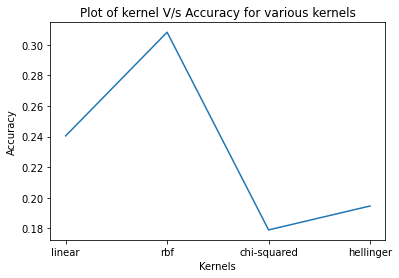

In [29]:
plt.plot(x_axis, y_axis)
plt.xlabel("Kernels")
plt.ylabel("Accuracy")
plt.title("Plot of kernel V/s Accuracy for various kernels")
plt.show()

In [ ]:
# Due to time and resources constraint, were unable to run for this kernel
model_linear = SVC(kernel=intersection)
model_linear.fit(train_x, train_y)
pred_y = model_linear.predict(test_x)
print("accuracy for Intersection kernel:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")
